In [1]:
import scanpy as sc
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
out_dir = 'output'
os.makedirs(out_dir, exist_ok = True)

In [3]:
Deg_Anca_Nuc = pd.read_csv(os.path.join(out_dir,'Diff_Genes_ANCA.csv'))
Deg_Anca_Nuc.head()

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
0,CDH6,182.95096,6.218638,0.0,0.0,0.607997
1,LRP2,155.85289,3.278870,0.0,0.0,0.635027
2,NEAT1,140.59508,1.382046,0.0,0.0,0.902077
3,RNF213,134.07849,2.357901,0.0,0.0,0.660138
4,SLC17A1,133.99812,3.217929,0.0,0.0,0.536076


In [4]:
Deg_Anca_Xen = pd.read_csv(os.path.join(out_dir,'Diff_Genes_ANCA_XENIUM.csv'))
Deg_Anca_Xen = Deg_Anca_Xen.add_suffix('_Xen')
Deg_Anca_Xen.head()

,names_Xen,scores_Xen,logfoldchanges_Xen,pvals_Xen,pvals_adj_Xen,pct_nz_group_Xen
0,SOD2,254.49077,1.764378,0.0,0.0,0.395534
1,ITGB1,221.98479,1.085175,0.0,0.0,0.436165
2,MSN,208.46971,1.186620,0.0,0.0,0.372237
3,HMGB1,195.18149,0.877852,0.0,0.0,0.414024
4,MGP,191.03287,2.406350,0.0,0.0,0.250742


In [5]:
Deg_Anca_Nuc = Deg_Anca_Nuc.rename(columns={'names': 'gene_nuc'})
Deg_Anca_Xen = Deg_Anca_Xen.rename(columns={'names_Xen': 'gene_xen'})

merged_Nuc_Xen = Deg_Anca_Nuc.merge(Deg_Anca_Xen, left_on='gene_nuc', right_on='gene_xen', how = 'outer')

## Selecting oinly the significant changes for Nuc-seq
#merged_Nuc_Xen = merged_Nuc_Xen[merged_Nuc_Xen.pvals_adj < 0.05]

## Overall heatmaps for Xenium and NucSeq

In [6]:
unwanted_strings = ['scores', 'pct_nz_group']
cols_to_drop = []

for col in merged_Nuc_Xen.columns:
    for keyword in unwanted_strings:
        if keyword in col:
            cols_to_drop.append(col)
            break  # no need to check other keywords


cols_to_drop=cols_to_drop+['pvals', 'pvals_Xen']
cols_to_drop

merged_Nuc_Xen.drop(columns =cols_to_drop, inplace= True)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.api.types import CategoricalDtype

def plot_heatmap_tech_FC(df, tile_size=(0.3, 1.5), gene_group='ADAM', max_genes_per_row=26, out_dir='./output'):
    
    df = df.rename(columns={'logfoldchanges': 'Nuc-seq', 'logfoldchanges_Xen': 'Xenium'}).copy()

    # Compute global vmin/vmax
    fc_vals_all = df[['Nuc-seq', 'Xenium']].values.flatten()
    fc_vals_all = fc_vals_all[~np.isnan(fc_vals_all)]
    if len(fc_vals_all) == 0:
        abs_max = 0.5  # fallback if all NaN
    else:
        abs_max = np.abs(fc_vals_all).max()
        abs_max = 5 if abs_max > 5 else max(abs_max, 0.5)
    vmin, vmax = -abs_max, abs_max

    # Prepare gene list and chunking
    gene_list = df['gene_nuc'].cat.categories if isinstance(df['gene_nuc'].dtype, CategoricalDtype) else df['gene_nuc'].unique()
    chunks = [list(gene_list[i:i + max_genes_per_row]) for i in range(0, len(gene_list), max_genes_per_row)]
    max_cols = max(len(chunk) for chunk in chunks)

    # Calculate figure size
    tile_w, tile_h = tile_size
    num_chunks = len(chunks)
    fig_width = tile_w * max_cols
    fig_height = tile_h * 2 * num_chunks

    fig, axes = plt.subplots(
        nrows=num_chunks,
        figsize=(fig_width, fig_height),
        squeeze=False,
        gridspec_kw={'height_ratios': [1] * num_chunks, 'hspace': 0.5}
    )

    for i, gene_chunk in enumerate(chunks):
        padded_chunk = gene_chunk + [f"pad_{j}" for j in range(max_cols - len(gene_chunk))]
        df_chunk = df[df['gene_nuc'].isin(gene_chunk)].copy()

        # Pad for consistent heatmap layout
        pad_rows = []
        for g in padded_chunk:
            if g not in df_chunk['gene_nuc'].values:
                pad_rows.append({
                    'gene_nuc': g,
                    'Nuc-seq': np.nan,
                    'Xenium': np.nan,
                    'pvals_adj': np.nan,
                    'pvals_adj_Xen': np.nan
                })
        if pad_rows:
            df_chunk = pd.concat([df_chunk, pd.DataFrame(pad_rows)], ignore_index=True)

        df_melted = df_chunk.melt(
            id_vars='gene_nuc',
            value_vars=['Nuc-seq', 'Xenium'],
            var_name='technique',
            value_name='Log2FC'
        )
        df_melted['gene_nuc'] = pd.Categorical(df_melted['gene_nuc'], categories=padded_chunk, ordered=True)
        df_melted['Log2FC'] = df_melted['Log2FC'].clip(vmin, vmax)

        # Melt p-values for annotation
        pvals_adj_chunk = df_chunk.melt(
            id_vars='gene_nuc',
            value_vars=['pvals_adj', 'pvals_adj_Xen'],
            var_name='technique',
            value_name='padj_value'
        )
        pvals_adj_chunk['technique'] = pvals_adj_chunk['technique'].replace({
            'pvals_adj': 'Nuc-seq',
            'pvals_adj_Xen': 'Xenium'
        })
        pvals_adj_chunk['gene_nuc'] = pd.Categorical(pvals_adj_chunk['gene_nuc'], categories=padded_chunk, ordered=True)

        df_melted = df_melted.merge(pvals_adj_chunk, on=['gene_nuc', 'technique'])

        heatmap_df = df_melted.pivot(index='technique', columns='gene_nuc', values='Log2FC').reindex(columns=padded_chunk)
        annot_df = df_melted.pivot(index='technique', columns='gene_nuc', values='padj_value') \
            .apply(lambda col: col.map(lambda x: '*' if pd.notnull(x) and x < 0.05 else '')) \
            .reindex(columns=padded_chunk)

        clean_labels = ['' if str(g).startswith("pad_") else g for g in padded_chunk]

        ax = axes[i, 0]
        sns.heatmap(
            heatmap_df,
            cmap='coolwarm',
            center=0,
            vmin=vmin,
            vmax=vmax,
            linewidths=0.5,
            linecolor='black',
            square=True,
            annot=annot_df,
            fmt='',
            cbar=False,
            ax=ax
        )

        ax.set_xticklabels(clean_labels, rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xlabel('')
        ax.set_ylabel('')

        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_edgecolor('black')

    # Title
    fig.suptitle(f'{gene_group} genes', fontsize=14, y=1.02)

    # Consistent colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])

    divider = make_axes_locatable(axes[-1, 0])
    cbar_ax = divider.append_axes("bottom", size=0.1, pad=1.0)
    fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Log2 FC')

    plt.tight_layout()
    plt.subplots_adjust(left=0.35, bottom=0.1, top=0.92)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    plt.savefig(os.path.join(out_dir, f'XENvsNUC_Heatmap_Nuc_Xen_{gene_group}_genes.pdf'))
    plt.savefig(os.path.join(out_dir, f'XENvsNUC_Heatmap_Nuc_Xen_{gene_group}_genes.png'))

    plt.show()

    

### Filter gene groups and plot

/tmp/ipykernel_20827/2994807688.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  drop_mask = df_ADAM['gene_nuc'].str.contains(r'(AS1|AS2)$', na=False)
/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


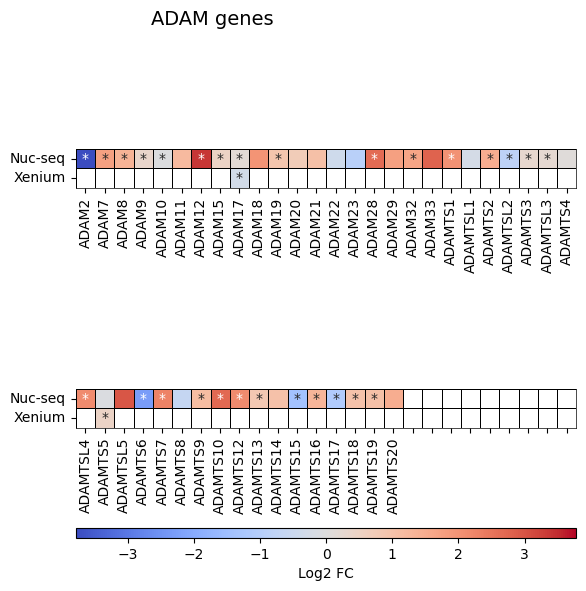

In [8]:
import re

def custom_adam_sort_key(gene):
    if gene.startswith('ADAMTS'):
        group = 1
        num = re.search(r'\d+', gene)
        return (group, int(num.group()) if num else float('inf'), gene)
    elif gene.startswith('ADAM'):
        group = 0
        num = re.search(r'\d+', gene)
        return (group, int(num.group()) if num else float('inf'), gene)
    else:
        return (2, float('inf'), gene)  # Other ADAM* genes last

# Filter only ADAM* genes
df_ADAM = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.startswith('ADAM', na=False)].copy()

# ✅ Drop unwanted genes (ending in AS1 and ADAMDEC1)
#drop_mask = df_ADAM['gene_nuc'].str.endswith('AS1', na=False)
drop_mask = df_ADAM['gene_nuc'].str.contains(r'(AS1|AS2)$', na=False)
drop_genes = df_ADAM.loc[drop_mask, 'gene_nuc'].tolist() + ['ADAMDEC1']
df_ADAM = df_ADAM[~df_ADAM['gene_nuc'].isin(drop_genes)].copy()

# ✅ Sort gene names using custom key
sorted_genes = sorted(df_ADAM['gene_nuc'].unique(), key=custom_adam_sort_key)

# ✅ Apply order
df_ADAM['gene_nuc'] = pd.Categorical(df_ADAM['gene_nuc'], categories=sorted_genes, ordered=True)

# ✅ Plot
plot_heatmap_tech_FC(df_ADAM, tile_size=(0.35, 1.5), gene_group='ADAM')


/tmp/ipykernel_20827/3460614022.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_MAPK = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.contains(r'^(MAPK|PRKC|ILK)', na=False)].copy()
/tmp/ipykernel_20827/3460614022.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  drop_mask = df_MAPK['gene_nuc'].str.contains(r'(AP1|BP1|AS1|MAPK8IP|MAPKAPK)$', na=False)
/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


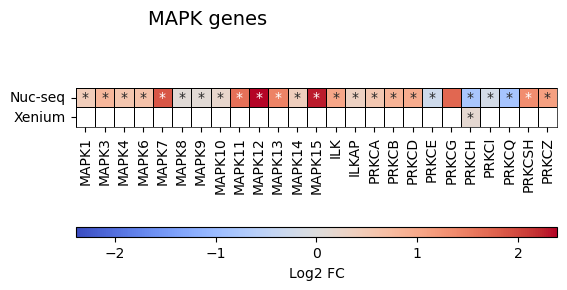

In [9]:
import re

def custom_MAPK_sort_key(gene):
    if gene.startswith('MAPK8IP') or gene.startswith('MAPKAPK') or gene.endswith('DT'):
        group = 2
        num = re.search(r'\d+', gene)
        return (group, int(num.group()) if num else float('inf'), gene)
    elif gene.startswith('MAPK'):
        group = 0
        num = re.search(r'\d+', gene)
        return (group, int(num.group()) if num else float('inf'), gene)
    else:
        return (1, float('inf'), gene)  # Other MAPK* genes last

# Filter only MAPK* genes
#df_MAPK = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.startswith('MAPK', na=False)].copy()
df_MAPK = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.contains(r'^(MAPK|PRKC|ILK)', na=False)].copy()


# ✅ Drop unwanted genes (ending in AS1 and MAPKDEC1)
#drop_mask = df_MAPK['gene_nuc'].str.endswith('AS1', na=False)
drop_mask = df_MAPK['gene_nuc'].str.contains(r'(AP1|BP1|AS1|MAPK8IP|MAPKAPK)$', na=False)
drop_genes = df_MAPK.loc[drop_mask, 'gene_nuc'].tolist() + ['MAPK1IP1L', 'MAPKAPK5-AS1', 'MAPKAPK2','MAPKAPK3','MAPKAPK5','MAPK8IP1','MAPK8IP2','MAPK8IP3','MAPK6-DT']
df_MAPK = df_MAPK[~df_MAPK['gene_nuc'].isin(drop_genes)].copy()

# ✅ Sort gene names using custom key
sorted_genes = sorted(df_MAPK['gene_nuc'].unique(), key=custom_MAPK_sort_key)

# ✅ Apply order
df_MAPK['gene_nuc'] = pd.Categorical(df_MAPK['gene_nuc'], categories=sorted_genes, ordered=True)

# ✅ Plot
plot_heatmap_tech_FC(df_MAPK, tile_size=(0.35, 1.5), gene_group='MAPK')


/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


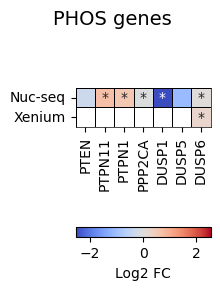

In [10]:
gene_list = ['PTEN', 'PTPN11', 'PTPN1', 'PPP2CA', 'DUSP1', 'DUSP5', 'DUSP6']

df_PHOS = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].isin(gene_list)].copy()

# Set gene_nuc as ordered categorical using manual list
df_PHOS['gene_nuc'] = pd.Categorical(df_PHOS['gene_nuc'], categories=gene_list, ordered=True)

# Plot
plot_heatmap_tech_FC(df_PHOS, tile_size=(0.35, 1.5), gene_group='PHOS')


/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


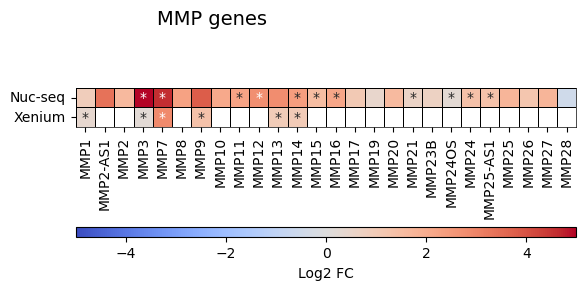

In [11]:
df_MMP = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.startswith('MMP', na=False)].copy()

# Extract numeric part and sort
df_MMP['gene_num'] = df_MMP['gene_nuc'].apply(lambda x: int(re.search(r'\d+', x).group()))
df_MMP = df_MMP.sort_values(by='gene_num')

# Lock in gene order as categorical
sorted_genes = df_MMP['gene_nuc'].unique()
df_MMP['gene_nuc'] = pd.Categorical(df_MMP['gene_nuc'], categories=sorted_genes, ordered=True)

df_MMP = df_MMP.drop(columns='gene_num')

# call the plot function
plot_heatmap_tech_FC(df_MMP, tile_size=(0.35, 1.5), gene_group='MMP')


/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


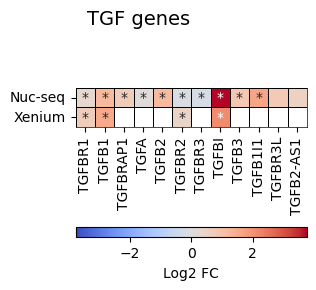

In [12]:
df_TGF = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.startswith('TGF', na=False)].copy()

# Extract numeric part and sort
#df_TGF['gene_num'] = df_TGF['gene_nuc'].apply(lambda x: int(re.search(r'\d+', x).group()))
#df_TGF = df_TGF.sort_values(by='gene_num')

# Lock in gene order as categorical
sorted_genes = df_TGF['gene_nuc'].unique()
df_TGF['gene_nuc'] = pd.Categorical(df_TGF['gene_nuc'], categories=sorted_genes, ordered=True)

#df_TGF = df_TGF.drop(columns='gene_num')

# call the plot function
plot_heatmap_tech_FC(df_TGF, tile_size=(0.35, 1.5), gene_group='TGF')

/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


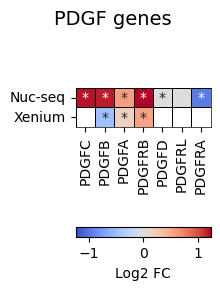

In [13]:
df_PDGF = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].str.startswith('PDGF', na=False)].copy()

# Extract numeric part and sort
#df_PDGF['gene_num'] = df_PDGF['gene_nuc'].apply(lambda x: int(re.search(r'\d+', x).group()))
#df_PDGF = df_PDGF.sort_values(by='gene_num')

# Lock in gene order as categorical
sorted_genes = df_PDGF['gene_nuc'].unique()
df_PDGF['gene_nuc'] = pd.Categorical(df_PDGF['gene_nuc'], categories=sorted_genes, ordered=True)

#df_PDGF = df_PDGF.drop(columns='gene_num')

# call the plot function
plot_heatmap_tech_FC(df_PDGF, tile_size=(0.35, 1.5), gene_group='PDGF')

/tmp/ipykernel_20827/3686168573.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


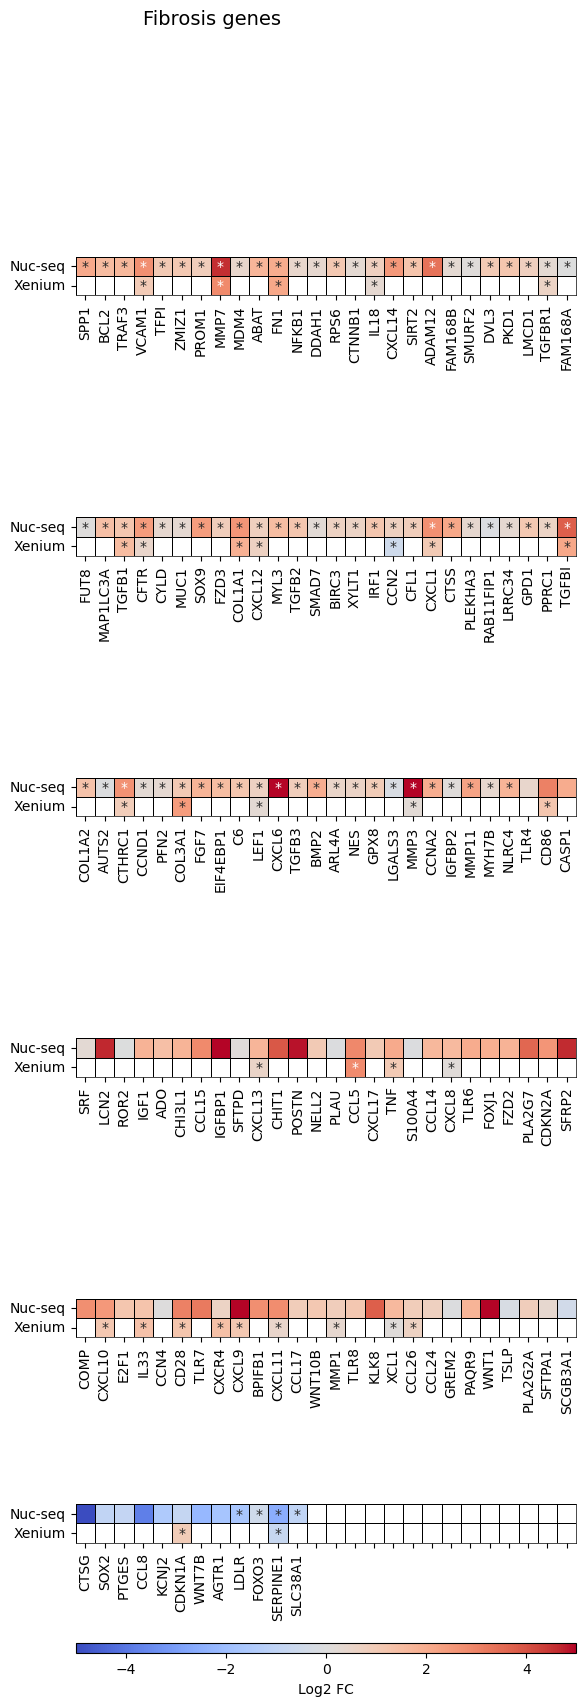

In [14]:
Fib_Genes_FDRdb= pd.read_csv('./Homo_sapiens_mRNA_FDs_info.csv')
#Downloaded mRNA for humans : http://www.medsysbio.org/FDRdb/download/

Fib_Genes_K = Fib_Genes_FDRdb[Fib_Genes_FDRdb.Tissue == 'kidney']
Fib_Genes_up = Fib_Genes_FDRdb[Fib_Genes_FDRdb.Expression == 'up-regulation']

fibrosis_genes = Fib_Genes_up.symbol.unique()

fibrosis_genes_df = merged_Nuc_Xen[merged_Nuc_Xen['gene_nuc'].isin(fibrosis_genes)].copy()
plot_heatmap_tech_FC(fibrosis_genes_df, tile_size=(0.35, 1.5),gene_group='Fibrosis')